## Prediction
Upload models in sequence, append their predictions in sequence, and then evaluate required results

1. [done] Deterministic write pipeline for producing df w [mean, std, actual]
2. [done] Train ensemble
3. [done] Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
4. Produce plot showing the selective prediction w uncertainty thresholding
5. Produce plot showing histology slide with companion aleatoric, epistemic, and total

RE 4. and 5. : "Outputs would include <br>
    a. revised uncertainty thresholding curves (i.e. , selective prediction), and <br>
    b. a few histopathology slides visualised, whereby each slide is shown 4 views: (1) RBG image, (2) mean estimate for each spot, (3) aleatoric uncertainty, (4) epistemic uncertainty"

Note that the quality of calculating the two separate components of uncertainty is contingent on the assumption that gene expressions are distributed following the negative binomial likelihood. 

Point I am unsure of: 
I understand it that the expectation of the posterior predictive will be closer to the true mean, regardless of whether the likelihood is or is not actually NB. However, I am not certain about this point since I have only read vague commentary about it. It would be nice to know and word this point properly, since if it is true, I think it is an appealing property of Bayesian inference. 

Enjoy the weekend

In [1]:
from pathlib import Path
from anndata import read_h5ad
import sys
import scanpy
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
# stimage custom 
file = Path("../stimage").resolve() # path to src code
parent = file.parent
sys.path.append(str(parent))

from tqdm import tqdm

from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator

import pickle

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")

## Constants

In [3]:
DATA_PATH = Path("/scratch/smp/uqsmac12/dataset_breast_cancer_9visium")

OUT_PATH = Path("/scratch/smp/uqsmac12/results")

OUT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

## Data loader

In [5]:
(DATA_PATH / "all_adata.h5ad").exists()

True

In [6]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

The annadata object `adata_all` contains STexpression readings for each spot (represented in a spotXexpression matrix). The bellow script accesses cell attribute information and updates the path.

In [7]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        "/scratch/smp/uqsmac12/dataset_breast_cancer_9visium"))

In [8]:
adata_all.obs["tile_path"][0]

'/scratch/smp/uqsmac12/dataset_breast_cancer_9visium/tiles/1142243F-12601-4511-299.jpeg'

In [9]:
# remove FFPE and 1160920F --- the test set
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())]

In [10]:
n_genes = len(gene_list)

training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "FFPE"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [11]:
train_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

## Get results from ensembles

### Save results

### Save ground truth

### Load results

In [5]:
with open(str(OUT_PATH / 'ensemble_results_1.pkl'), 'rb') as f:
    ensemble_results1 = pickle.load(f)

with open(str(OUT_PATH / 'ensemble_results_2.pkl'), 'rb') as f:
    ensemble_results2 = pickle.load(f)

### Load ground truth

In [6]:
with open(str(OUT_PATH / 'df_target_1.pkl'), 'rb') as f:
    df_target_1 = pickle.load(f)

with open(str(OUT_PATH / 'df_target_2.pkl'), 'rb') as f:
    df_target_2 = pickle.load(f)

## understanding `ensemble_results{e_id}`

`ensemble_results1` is a np array with 4 axes: `(samples, [n, p, mu, var], genes, simulations)`

In [7]:
ensemble_results1.shape

(2338, 4, 14, 10)

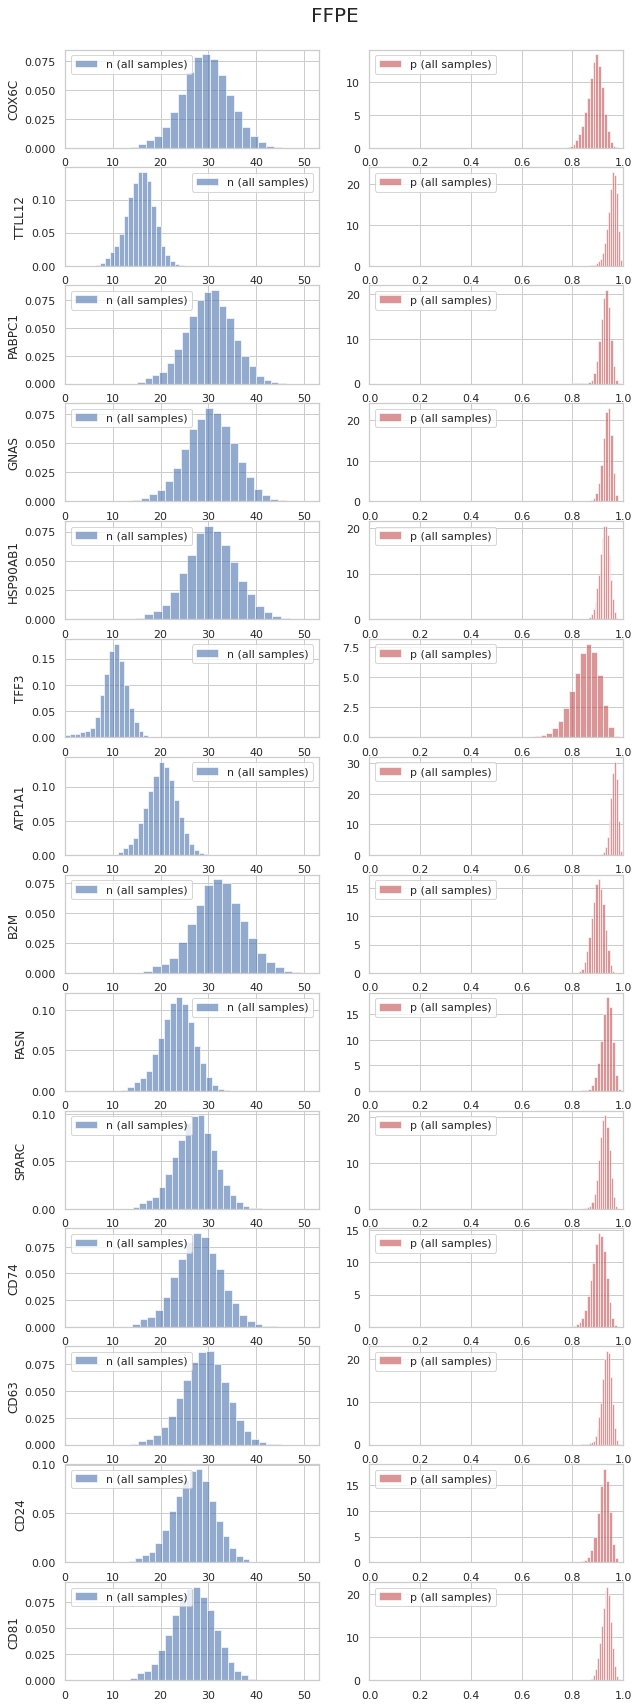

In [57]:
fig, ax = plt.subplots(nrows=len(gene_list), ncols=2, figsize=(10,30))
for gid, gn in enumerate(gene_list):
    
    p_all = ensemble_results1[:, 1, gid, :].reshape(-1)
    n_all = ensemble_results1[:, 0, gid, :].reshape(-1)
    
    ax[gid][0].hist(n_all, bins=20, label='n (all samples)', color='b', alpha=0.6, density=True)
    ax[gid][1].hist(p_all, bins=20, label='p (all samples)', color='r', alpha=0.6, density=True)
    # plt.hist(n_all, bins=100, label='n (all samples)', color='b', alpha=0.6)
    # plt.hist(p_all, bins=100, label='p (all samples)', color='r', alpha=0.6)
    ax[gid][0].set_xlim([0,ensemble_results1[:, 0, :, :].max()])
    ax[gid][1].set_xlim([0,1])
    ax[gid][0].legend()
    ax[gid][1].legend()
    ax[gid][0].set_ylabel(gn)
    
fig.suptitle('FFPE', fontsize=20, y=0.9)
fig.show()

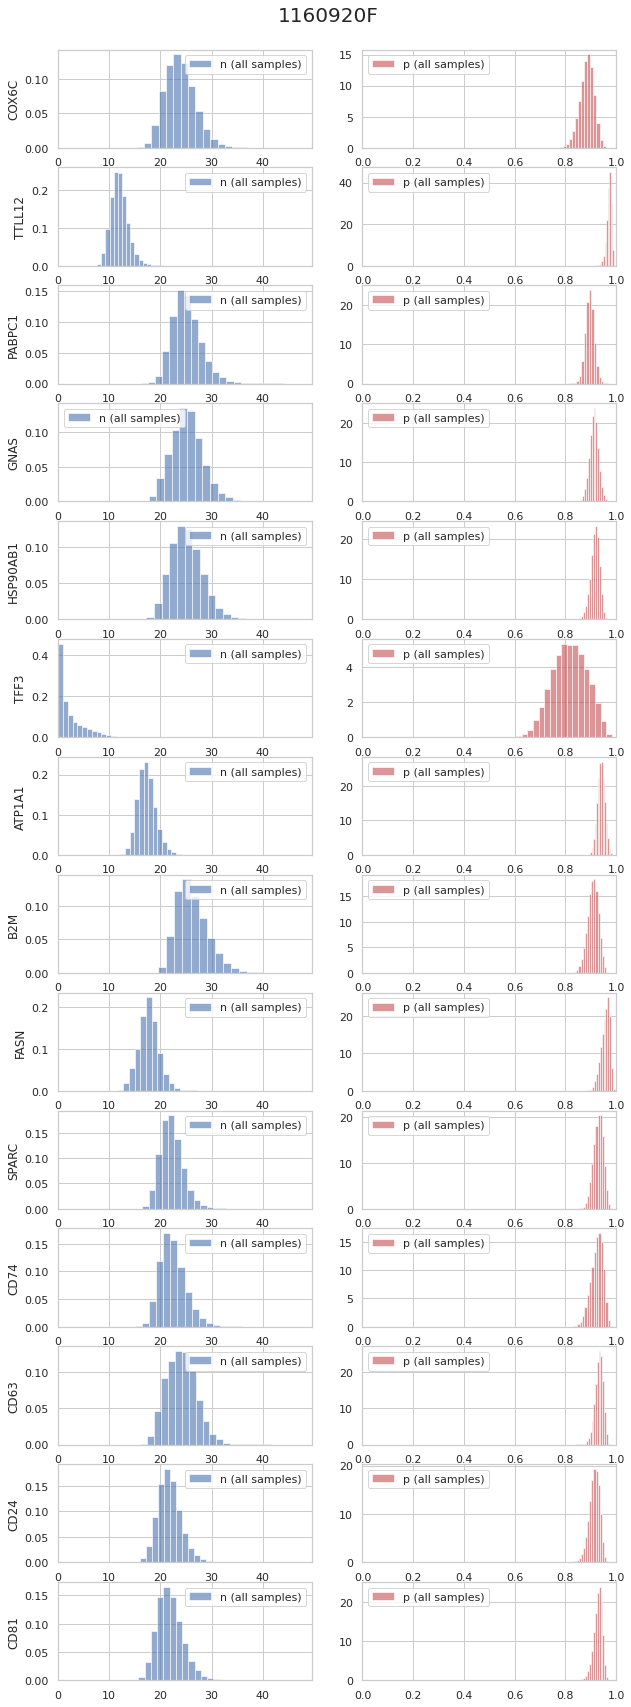

In [56]:
fig, ax = plt.subplots(nrows=len(gene_list), ncols=2, figsize=(10,30))
for gid, gn in enumerate(gene_list):
    
    p_all = ensemble_results2[:, 1, gid, :].reshape(-1)
    n_all = ensemble_results2[:, 0, gid, :].reshape(-1)
    
    ax[gid][0].hist(n_all, bins=20, label='n (all samples)', color='b', alpha=0.6, density=True)
    ax[gid][1].hist(p_all, bins=20, label='p (all samples)', color='r', alpha=0.6, density=True)
    # plt.hist(n_all, bins=100, label='n (all samples)', color='b', alpha=0.6)
    # plt.hist(p_all, bins=100, label='p (all samples)', color='r', alpha=0.6)
    ax[gid][0].set_xlim([0,ensemble_results2[:, 0, :, :].max()])
    ax[gid][1].set_xlim([0,1])
    ax[gid][0].legend()
    ax[gid][1].legend()
    ax[gid][0].set_ylabel(gn)
fig.suptitle('1160920F', fontsize=20, y=.9)
fig.show()

# Obtain uncertainty components
First we need to estimate $\mu_{\theta}(X) = \mathbb{E}[X|\theta]= r(1-p)/p$, as well as $\sigma^2_{\theta}(X) = \mathbb{V}[X|\theta]=r(1-p)/p^2$.

In [28]:
def get_nb_stats_with_correction(ens_res, min_k=.5, max_k=1.5):
    nb_mean = lambda n, p, k: n*(1-p*k)/(p*k)
    nb_var = lambda n, p, k: n*(1-p*k)/(p*p*k*k)
    
    dict_res_k = {}
    
    # n, p have shape (samples, genes, sims)
    n_, p_ = ens_res[:, 0, :, :], ens_res[:, 1, :, :]
    
    for k in np.arange(min_k, max_k, .01):
        k = round(k,2)
        
        mean_k = nb_mean(n_, p_, k)
        var_k = nb_var(n_, p_, k)
        
        dict_res_k[k] = np.stack([n_, p_, mean_k, var_k], axis=1)
        
    return dict_res_k

In [29]:
min_k = 0.5
max_k = 1.5

dict_res_k_1 = get_nb_stats_with_correction(ensemble_results1, min_k=.5, max_k=1.5)
dict_res_k_2 = get_nb_stats_with_correction(ensemble_results2, min_k=.5, max_k=1.5)

In [40]:
dict_res_k_1[1].shape

(2338, 4, 14, 10)

we have the mean and variance of multiple simulations and for multiple correction factors values k... lets test risk shedding for one single k first and then determine the best for all k.

$\mathbb{V}(X) = \mathbb{E}[{\mathbb{V}(X|\theta)}] + \mathbb{V}[{\mathbb{E}(X|\theta)}]$

In [37]:
def get_uncertainty_components(ens_res):
    """
    """
    # get E[E[X|f]], E[V[X|f]] 
    mean = ens_res[:,-2:,:,:].mean(axis=-1)
    # get V[E[X|f]], V[V[X|f]] 
    var = ens_res[:,-2:,:,:].var(axis=-1)
    # stack E(mean), V(mean), E(var), total
    res = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)
    
    return res

In [41]:
np_total_var1 = get_uncertainty_components(dict_res_k_1[1])
np_total_var2 = get_uncertainty_components(dict_res_k_2[1])

# Sanity check across all samples

## ...for `FFPE`

In [114]:
df_target_1.head(2)

,COX6C,TTLL12,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,SPARC,CD74,CD63,CD24,CD81
AAACAAGTATCTCCCA-1-FFPE,2.944439,0.693147,4.890349,2.484907,2.079442,0.0,2.397895,4.127134,0.000000,1.791759,2.639057,3.367296,3.871201,3.258096
AAACACCAATAACTGC-1-FFPE,1.098612,0.000000,3.044523,2.079442,1.609438,0.0,0.693147,3.610918,0.693147,2.302585,3.555348,2.833213,1.386294,1.791759


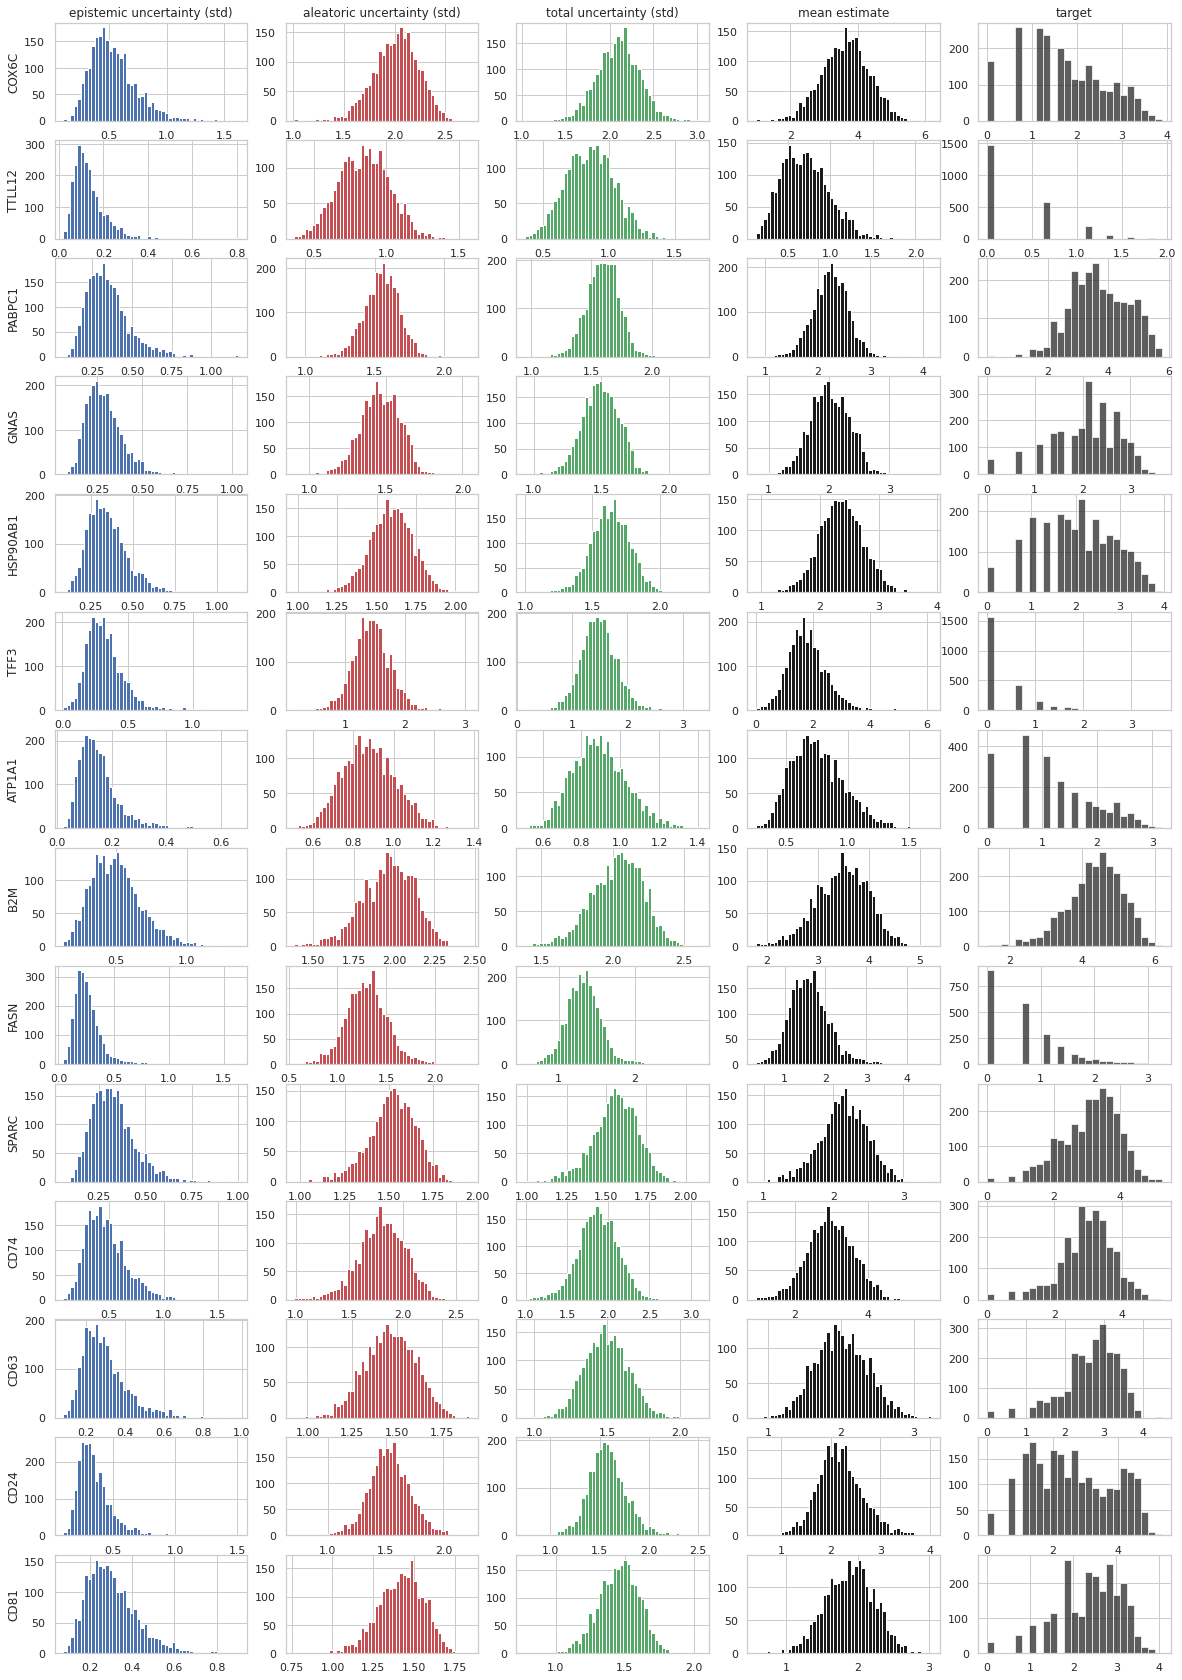

In [116]:
# mean = ensemble_results1[:,-2:,:,:].mean(axis=-1)
# var = ensemble_results1[:,-2:,:,:].var(axis=-1)
# np_total_var = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)

# E(mean), V(mean), E(var), total

fig, ax = plt.subplots(nrows=len(gene_list), ncols=5, figsize=(20, 30))

ax[0][0].set_title("epistemic uncertainty (std)")
ax[0][1].set_title("aleatoric uncertainty (std)")
ax[0][2].set_title("total uncertainty (std)")
ax[0][3].set_title("mean estimate")
ax[0][4].set_title("target")

for gid, gname in enumerate(gene_list):
    ax[gid][0].set_ylabel(gname)
    ax[gid][0].hist(np.sqrt(np_total_var1[:,1,gid]), bins=50, color='b')
    ax[gid][1].hist(np.sqrt(np_total_var1[:,2,gid]), bins=50, color='r')
    ax[gid][2].hist(np.sqrt(np_total_var1[:,3,gid]), bins=50, color='g')
    ax[gid][3].hist(np_total_var1[:,0,gid], bins=50, color='k')
    ax[gid][4].hist(df_target_1[gname], bins=25, color='k', alpha=0.7)
fig.show()

## ...for `1160920F`

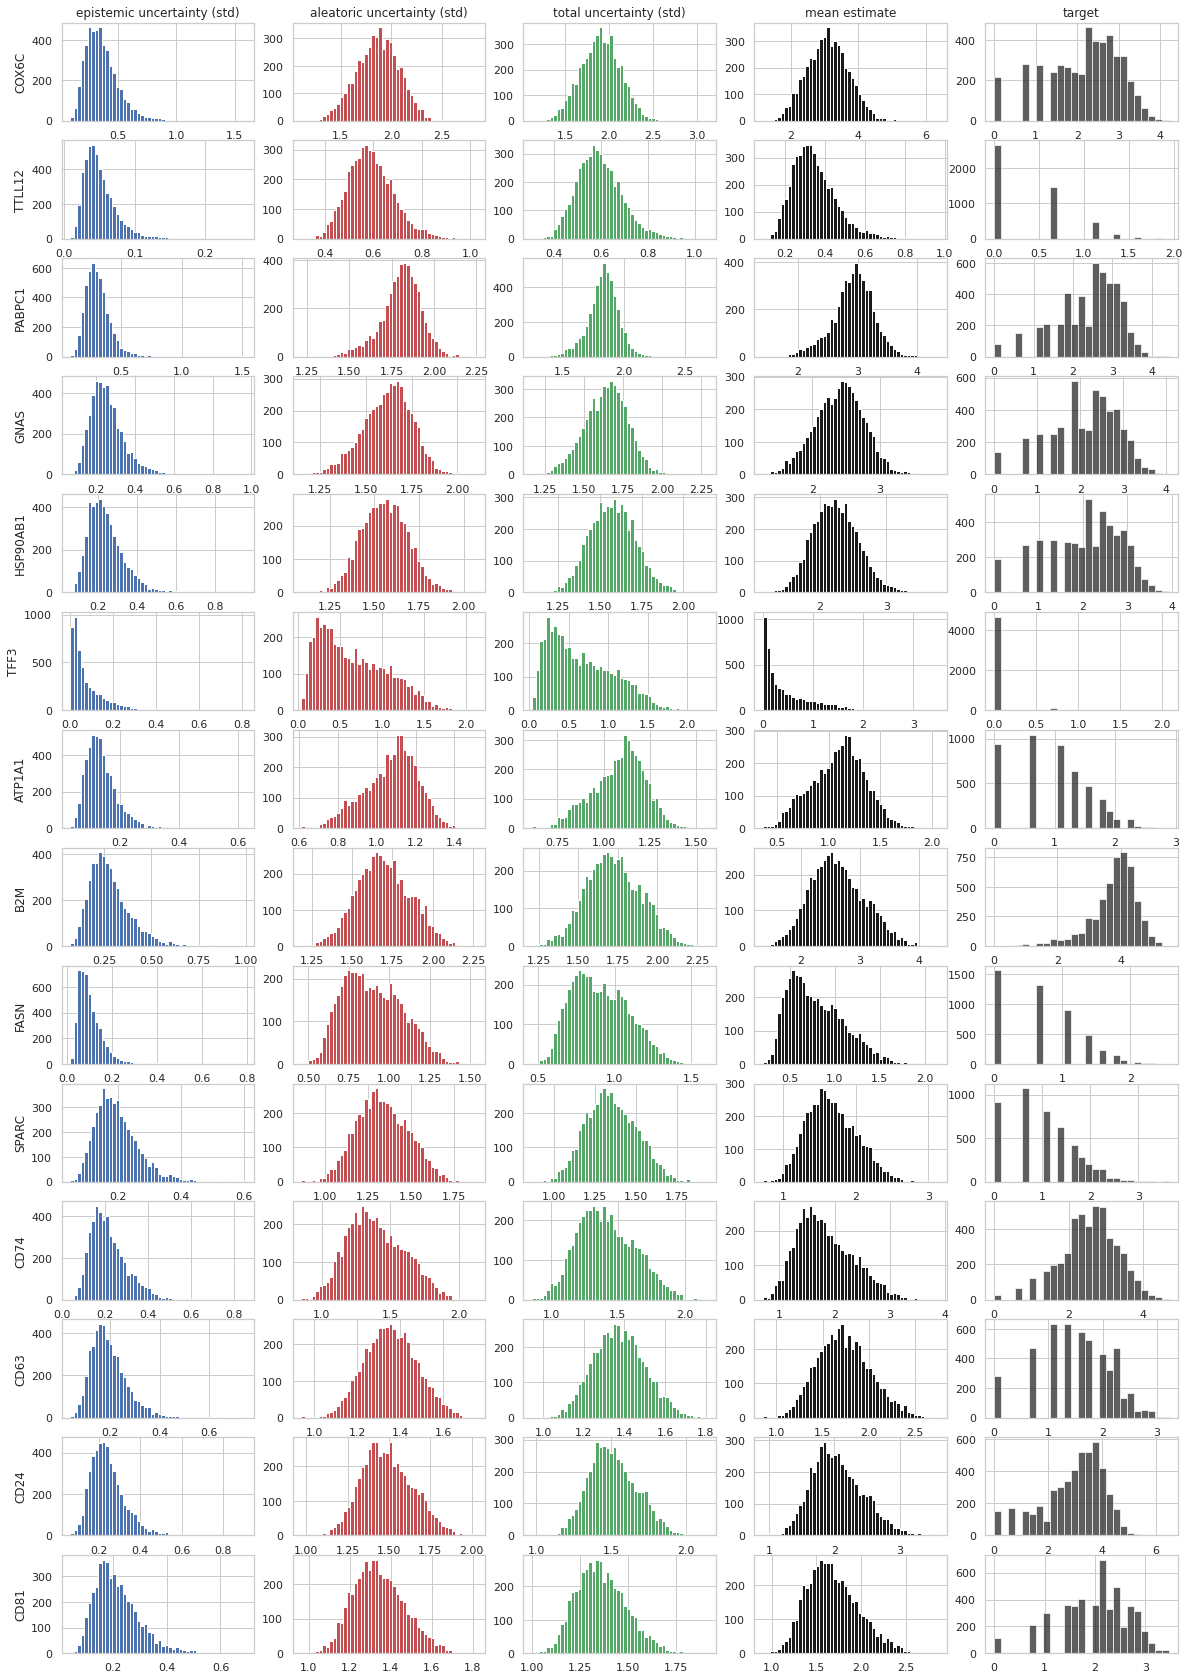

In [117]:
# mean = ensemble_results2[:,-2:,:,:].mean(axis=-1)
# var = ensemble_results2[:,-2:,:,:].var(axis=-1)
# np_total_var = np.stack([mean[:,0,:], var[:,0,:], mean[:,1,:], var[:,0,:]+mean[:,1,:]], axis=1)

# E(mean), V(mean), E(var), total

fig, ax = plt.subplots(nrows=len(gene_list), ncols=5, figsize=(20, 30))

ax[0][0].set_title("epistemic uncertainty (std)")
ax[0][1].set_title("aleatoric uncertainty (std)")
ax[0][2].set_title("total uncertainty (std)")
ax[0][3].set_title("mean estimate")
ax[0][4].set_title("target")

for gid, gname in enumerate(gene_list):
    ax[gid][0].set_ylabel(gname)
    ax[gid][0].hist(np.sqrt(np_total_var2[:,1,gid]), bins=50, color='b')
    ax[gid][1].hist(np.sqrt(np_total_var2[:,2,gid]), bins=50, color='r')
    ax[gid][2].hist(np.sqrt(np_total_var2[:,3,gid]), bins=50, color='g')
    ax[gid][3].hist(np_total_var2[:,0,gid], bins=50, color='k')
    ax[gid][4].hist(df_target_2[gname], bins=25, color='k', alpha=.7)
    
fig.show()

In [161]:
m1_res_1 = ensemble_results1[:,2,:,2]

(2338, 14)

## Performance of individual models, for `FFPE`

In [167]:
dict_corr_ffpe = {g: [] for g in gene_list}
for m in range(10):
    m1_res_1 = ensemble_results1[:,2,:,m]
    
    for i, g in enumerate(gene_list):
        dict_corr_ffpe[g].append(pearsonr(df_target_1[g], m1_res_1[:, i])[0])

In [170]:
df_corr_ffpe = pd.DataFrame(dict_corr_ffpe)
df_corr_ffpe

,COX6C,TTLL12,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,SPARC,CD74,CD63,CD24,CD81
0,0.050260,0.085860,0.142521,0.094000,0.152935,0.123960,0.439796,0.238536,0.210456,0.003836,0.194096,0.277815,0.276144,0.189424
1,0.310188,0.003461,0.186430,0.218650,0.124297,0.203027,0.340886,-0.002145,0.242070,0.010474,0.165299,0.289730,0.397094,0.088042
2,0.094464,0.017486,0.207329,0.361057,0.348422,0.230954,0.278947,-0.105370,0.195362,0.095023,0.287319,0.103898,0.383454,0.152394
3,-0.084009,0.018586,0.077925,0.155600,0.146405,0.280117,0.365998,0.058610,0.384215,0.141734,0.276308,0.244928,0.243770,0.242979
4,0.144904,0.034576,0.241828,0.255794,-0.027956,0.282105,0.305474,0.048398,0.204833,0.002645,0.283524,0.247170,0.117608,0.254648
5,0.140219,0.096551,0.088588,0.222831,0.207262,0.334121,0.523632,0.238918,0.174238,-0.143371,0.289114,0.256799,0.289226,0.102850
6,0.299334,0.006609,0.116472,-0.012927,0.212610,0.191354,0.450118,0.080272,0.152925,0.064128,0.301593,0.040920,0.316317,0.225615
7,0.177330,0.083921,0.091118,0.355310,0.128757,0.159296,0.304846,0.201909,0.377800,0.000794,0.233925,0.319811,0.510390,0.196858
8,-0.007730,0.100111,-0.173608,0.105298,0.306294,0.239535,0.494243,0.133302,0.316836,0.112905,0.219248,0.089356,0.316276,0.068811
9,0.074036,0.029050,0.264425,0.245836,0.080486,0.200158,0.516406,0.252301,0.276522,0.197416,0.257847,0.344039,0.332767,0.338801


In [171]:
df_corr_ffpe.mean()

COX6C       0.119900
TTLL12      0.047621
PABPC1      0.124303
GNAS        0.200145
HSP90AB1    0.167951
TFF3        0.224463
ATP1A1      0.402035
B2M         0.114473
FASN        0.253526
SPARC       0.048559
CD74        0.250827
CD63        0.221447
CD24        0.318305
CD81        0.186042
dtype: float64

In [172]:
df_corr_ffpe.std()

COX6C       0.123922
TTLL12      0.039197
PABPC1      0.123770
GNAS        0.117216
HSP90AB1    0.108223
TFF3        0.062546
ATP1A1      0.093728
B2M         0.119472
FASN        0.082468
SPARC       0.095486
CD74        0.045897
CD63        0.104808
CD24        0.103292
CD81        0.084577
dtype: float64

In [128]:
for g1, g2 in zip(df_target_1.columns, gene_list):
    print(g1==g2)

True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [108]:
np_target1[:,0,i].shape

(2338,)

In [ ]:
# # this is uploaded above
# # ground truth / target information
# df_target_1 = test_dataset_1.to_df().loc[:, gene_list]
# df_target_2 = test_dataset_2.to_df().loc[:, gene_list]

In [44]:
# append targets to predictions
np_target1 = df_target_1.values.reshape(len(df_target_1), 1, len(df_target_1.columns))
np_total_var1 = np.append(np_total_var1, np_target1, axis=1)

np_target2 = df_target_2.values.reshape(len(df_target_2), 1, len(df_target_2.columns))
np_total_var2 = np.append(np_total_var2, np_target2, axis=1)

In [45]:
dict_res1 = {g: np_total_var1[:,:,i] for i, g in enumerate(gene_list)}
dict_res2 = {g: np_total_var2[:,:,i] for i, g in enumerate(gene_list)}

In [46]:
list_dfs1 = []
for g in dict_res1.keys():
    df = pd.DataFrame(dict_res1[g], columns=['mean', 'epistemic', 'aleatoric', 'total', 'actual'])
    df['gene_name'] = g
    list_dfs1.append(df)
df_res1 = pd.concat(list_dfs1, axis=0)

list_dfs2 = []
for g in dict_res2.keys():
    df = pd.DataFrame(dict_res2[g], columns=['mean', 'epistemic', 'aleatoric', 'total', 'actual'])
    df['gene_name'] = g
    list_dfs2.append(df)
df_res2 = pd.concat(list_dfs2, axis=0)

In [49]:
df_res1.head(2)

,mean,epistemic,aleatoric,total,actual,gene_name
0,3.264449,0.356792,3.558751,3.915543,2.944439,COX6C
1,3.660281,0.328427,4.163891,4.492318,1.098612,COX6C


In [48]:
df_res2.head(2)

,mean,epistemic,aleatoric,total,actual,gene_name
0,4.150240,0.212050,4.912806,5.124856,0.000000,COX6C
1,3.975256,0.364937,4.611142,4.976080,0.693147,COX6C


In [50]:
df_res1['sample_name'] = 'FFPE'
df_res2['sample_name'] = '1160920F'

In [51]:
df_res = pd.concat([df_res1, df_res2], axis=0)

In [52]:
df_res.shape

(99694, 7)

In [53]:
df_res.head(2)

,mean,epistemic,aleatoric,total,actual,gene_name,sample_name
0,3.264449,0.356792,3.558751,3.915543,2.944439,COX6C,FFPE
1,3.660281,0.328427,4.163891,4.492318,1.098612,COX6C,FFPE


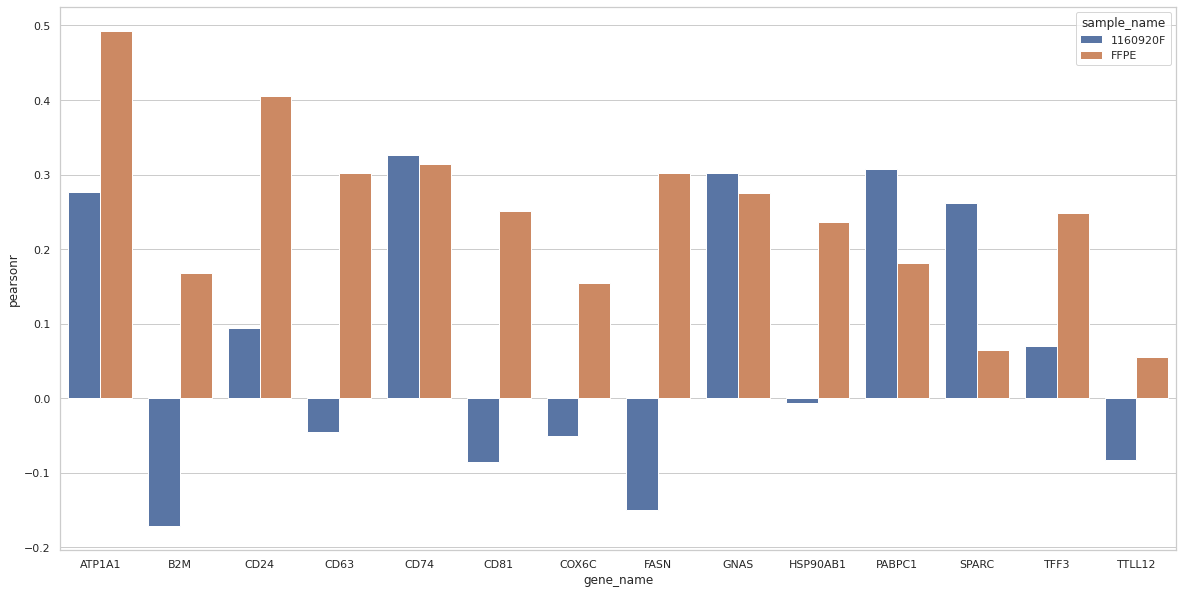

In [66]:
# pearsonr(df_res_all['target'], df_res_all['mean'])
df_sample_gene = df_res.groupby(['sample_name', 'gene_name']).apply(lambda x: pearsonr(x['actual'], x['mean'])[0])
df_sample_gene.name = 'pearsonr'
df_sample_gene = df_sample_gene.reset_index()

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="gene_name", y="pearsonr", hue="sample_name", data=df_sample_gene, ax=ax)
fig.show()

In [77]:
df_sample_gene.groupby('sample_name').agg(func=['mean', 'std'])

pearsonr          
                 mean       std
sample_name                    
1160920F     0.074526  0.184876
FFPE         0.246507  0.119543

In [74]:
df_res.head(2)

,mean,epistemic,aleatoric,total,actual,gene_name,sample_name
0,3.264449,0.356792,3.558751,3.915543,2.944439,COX6C,FFPE
1,3.660281,0.328427,4.163891,4.492318,1.098612,COX6C,FFPE


In [82]:
df_res_ffpe = df_res.loc[df_res.sample_name == 'FFPE', ].copy()

In [90]:
dict_corr_genes = {}
for g in gene_list:
    df_ = df_res_ffpe.loc[df_res_ffpe.gene_name == g,:]
    dict_corr_genes[g] = pearsonr(df_['actual'], df_['mean'])[0]
sr_correlations_gene_ffpe = pd.Series(dict_corr_genes,)

In [95]:
# what is the correlation of the mean predictor?
sr_mean_ = df_res_ffpe.groupby('gene_name')['actual'].mean()

df_res_ffpe['mean_pred'] = df_res_ffpe['gene_name'].apply(lambda x: sr_mean_[x])

pearsonr(df_res_ffpe['mean_pred'], df_res_ffpe['actual'])

<AxesSubplot:>

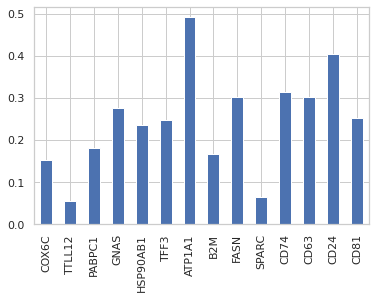

In [92]:
sr_correlations_gene_ffpe.plot.bar()

In [86]:
df_correlations_gene_ffpe

,COX6C,TTLL12,PABPC1,GNAS,HSP90AB1,TFF3,ATP1A1,B2M,FASN,SPARC,CD74,CD63,CD24,CD81
0,1.538435e-01,0.055776,1.812005e-01,2.757381e-01,2.366861e-01,2.489440e-01,4.920678e-01,1.677009e-01,3.019957e-01,0.064396,3.142338e-01,3.015430e-01,4.052342e-01,2.517394e-01
1,7.468318e-14,0.006984,1.046128e-18,4.597234e-42,3.951759e-31,2.323991e-34,7.784128e-143,3.285650e-16,1.682809e-50,0.001838,9.593998e-55,2.394182e-50,4.126877e-93,4.018083e-35


In [69]:
df_sample = df_res.groupby(['sample_name']).apply(lambda x: pearsonr(x['actual'], x['mean'])[0])
df_sample.name = 'pearsonr'
df_sample = df_sample.reset_index()

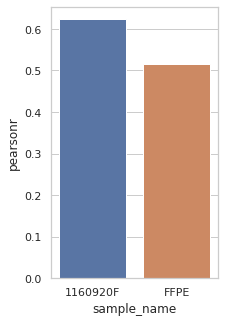

In [72]:
fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(x="sample_name", y="pearsonr", data=df_sample, ax=ax)
fig.show()

In [73]:
df_sample.head()

,sample_name,pearsonr
0,1160920F,0.622512
1,FFPE,0.515410


In [89]:
df_res.groupby(['sample_name']).apply(lambda x: pearsonr(x['actual'], x['mean'])[0]).mean()

0.5689612171123308

In [69]:
# get predictions 
pred_test_1 = model.predict(test_gen__1)
pred_test_2 = model.predict(test_gen__2)

NameError: name 'model' is not defined

In [30]:
pred_test_1[0].shape

(2338, 2)

In [ ]:
pred_test_1.shape

In [32]:
res = get_samples_stats_geneid(pred_test_1, gene_list)

In [33]:
res.shape

(2338, 4, 14)

In [114]:
def get_results(df_target, np_preds, list_genes):
    
    # instantiate dictionary
    dict_results = {}
    
    for gene_idx, gene_name in enumerate(list_genes):
        
        # actual 
        target = df_target[gene_name]

        # predicted NB params 
        n, p = np_preds[gene_idx][:,0], np_preds[gene_idx][:,1]
        
        # mean, var, std 
        mu, var = nbinom.stats(n, p, moments='mv')
        std = np.sqrt(var)

        # create dataframe
        df_temp = pd.DataFrame(
            data=np.stack([mu, var, std, target], axis=1), 
            columns=['mean', 'var', 'std', 'target'],
            index= df_target.index
        )
        
        # append dictionary
        dict_results[gene_name] = df_temp
        
    return dict_results

In [135]:
tf.random.set_seed()

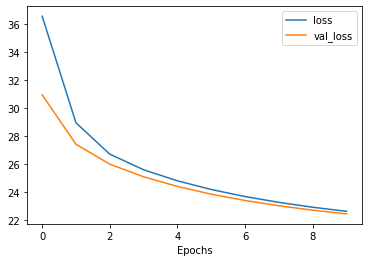

In [22]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [34]:
test_dataset_1??

In [45]:
# TO DO

# 1. deterministic write pipeline for producing df w [mean, std, actual]
# 1.5. train ensemble
# 2. Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
# 3. produce plot showing the selective prediction w uncertainty thresholding
# 4. produce plot showing histology slide with companion aleatoric, epistemic, and total

# 
# Draft results by end of week 2 (Feb-17th)

(2338, 14)

In [ ]:
test_dataset_1

In [89]:
df_temp.head()

,mean,var,std,target
0,2.935439,4.074678,2.018583,2.944439
1,5.838997,11.633478,3.410788,1.098612
2,7.910624,17.247154,4.152969,2.079442
3,4.063245,6.980574,2.642078,1.098612
4,4.097795,6.987684,2.643423,0.693147


In [98]:
df_target = df_target_1.copy()
np_preds = pred_test_1.copy()
list_genes = gene_list.copy()

In [107]:
dict_res1 = get_results(
    df_target = df_target_1, 
    np_preds = pred_test_1,
    list_genes = gene_list
)

In [115]:
dict_res2 = get_results(
    df_target = df_target_2, 
    np_preds = pred_test_2,
    list_genes = gene_list
)

In [128]:
df_res1_all = pd.concat([dict_res1[g] for g in dict_res1.keys()], axis=0)
df_res2_all = pd.concat([dict_res2[g] for g in dict_res2.keys()], axis=0)

In [129]:
df_res_all = pd.concat([df_res1_all, df_res2_all], axis=0)

In [131]:
pearsonr(df_res1_all['target'], df_res1_all['mean'])

(0.2762159394096582, 0.0)

In [132]:
pearsonr(df_res2_all['target'], df_res2_all['mean'])

(0.5736514250260873, 0.0)

In [130]:
pearsonr(df_res_all['target'], df_res_all['mean'])

(0.4494130066977668, 0.0)

In [121]:
pearsonr(dict_res2['COX6C']['mean'], dict_res2['COX6C']['target'])

(-0.1027875138788497, 1.0353204570941155e-12)

In [117]:
dict_res2['COX6C'].head()

,mean,var,std,target
TGGTACCGGCACAGCC-1-1160920F,3.259137,5.483247,2.341633,0.000000
GCGCGTTTAAATCGTA-1-1160920F,2.897606,4.424093,2.103353,0.693147
TGCCTTGCCCTTACGG-1-1160920F,4.820837,9.262687,3.043466,1.098612
GACGACTTTCCAAGAA-1-1160920F,3.893397,6.666375,2.581932,1.791759
CCAGTGAGCTCCTTGT-1-1160920F,1.962099,2.708454,1.645738,0.000000
